**OBJECTIVE:** Run modSAR algorithm on QSAR datasets 

In [1]:
import math
import numpy as np
import pandas as pd

# Import relevant modSAR classes 
from modSAR.network_algorithms import ModSAR
from modSAR.cdk_utils import CDKUtils
from modSAR.datasource import GenericFileDataSource
from modSAR.preprocessing import *
from modSAR.dataset import QSARDataset, QSARDatasetIO

from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit.Geometry
from rdkit.Chem import rdFMCS
from rdkit.Chem.Draw import IPythonConsole 

#from gevent import monkey
#monkey.patch_all()

# 2.5uM in Log units
CUTOFF_ACTIVITY = - np.log10(2.5e-06)

%matplotlib inline

/opt/conda/lib/python3.6/site-packages/grequests.py:21: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.contrib.pyopenssl (/opt/conda/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py)', 'urllib3.util (/opt/conda/lib/python3.6/site-packages/urllib3/util/__init__.py)']. 
  curious_george.patch_all(thread=False, select=False)


# Load Data

In [2]:
osm4_dataset = \
    QSARDatasetIO.load(dataset_name='OSM4',
                   activity_sheetname='activity',
                   smiles_column='Canonical_Smiles',
                   id_column='OSM_ID',
                   filepath='/mnt/data/OSM-S4/osm4_qsardataset.xls',
                   calculate_similarity=False)
    
similarity_matrix = pd.read_csv('/mnt/data/OSM-S4/similarity_values.csv', index_col='OSM_ID')
    
osm4_dataset

QSARDataset OSM4 
 -- Samples : 348
 -- Features:  95

In [73]:
similarity_matrix.shape

(345, 345)

## Manually remove invalid entries

There were three entries (rows) with NaN values:

In [58]:
sum(osm4_dataset.X.isnull().sum(axis=1) > 0)

3

In [59]:
invalid_entries = osm4_dataset.X.index[osm4_dataset.X.isnull().sum(axis=1) > 0]
invalid_entries

Index(['OSM-S-418', 'OSM-S-424', 'OSM-S-564'], dtype='object', name='OSM_ID')

In [67]:
osm4_dataset.X = osm4_dataset.X.drop(invalid_entries)
osm4_dataset.X_norm = osm4_dataset.X_norm.drop(invalid_entries)
osm4_dataset.y = osm4_dataset.y.drop(invalid_entries)
osm4_dataset.metadata = osm4_dataset.metadata.drop(invalid_entries)
osm4_dataset.number_samples = osm4_dataset.X.shape[0]

similarity_matrix = similarity_matrix.drop(invalid_entries)
similarity_matrix = similarity_matrix.drop(columns=invalid_entries)

osm4_dataset

QSARDataset OSM4 
 -- Samples : 345
 -- Features:  95

In [72]:
similarity_matrix.shape

(345, 345)

# Run ModSAR algorithm

Create an instance of modSAR algorithm and run `<ModSAR obj>.fit()` function with molecular descriptors, outcome variable and pairwise similarity:

In [284]:
osm4_dataset.y[osm4_dataset.y <= CUTOFF_ACTIVITY] = CUTOFF_ACTIVITY

In [236]:
alg = ModSAR(lam=0.005)

alg.fit(osm4_dataset.X_norm, osm4_dataset.y, 
        similarity_matrix.values, 
        osm4_dataset.metadata.Canonical_Smiles)

ModSAR(beta=0.03, epsilon=0.01, lam=0.005, solver_name='cplex')


/mnt/code/modSAR/graph.py:23: RuntimeWarning: invalid value encountered in less
  if (similarity_matrix < 0).any() or (similarity_matrix > 1).any():
/mnt/code/modSAR/graph.py:23: RuntimeWarning: invalid value encountered in greater
  if (similarity_matrix < 0).any() or (similarity_matrix > 1).any():
/mnt/code/modSAR/graph.py:28: RuntimeWarning: invalid value encountered in greater_equal
  thresholdMat = (similarity_matrix >= threshold) * similarity_matrix


Best Threshold = 0.20 | ACC = 0.886
Threshold: 0.2 | k: 0
Communities: Counter({'m02': 207, 'm01': 52, 'm03': 49, 'm04': 37})
Num. samples in comm m01: 52
OplraRegularised(beta=0.03, epsilon=0.01, exact_number_regions=None,
         lam=0.005, solver_name='cplex')
########## R = 1
SELECTED FEATURES:
['BCUTw-1l', 'BCUTc-1l', 'BCUTp-1h', 'LipinskiFailures', 'nBase', 'TopoPSA', 'MDEC-11', 'MDEC-22', 'MDEO-11', 'MDEO-12', 'MDEO-22', 'MDEN-23', 'MDEN-33', 'khs.sCH3', 'khs.ssCH2', 'khs.dsCH', 'khs.tsC', 'khs.dssC', 'khs.ssssC', 'khs.sNH2', 'khs.sssN', 'khs.sOH', 'khs.sCl', 'FMF', 'C3SP2', 'ATSm1', 'ATSc5', 'nHBDon', 'topoShape']

None

OplraRegularised(beta=0.03, epsilon=0.01, exact_number_regions=None,
         lam=0.005, solver_name='cplex')
########## R = 2 f* = BCUTw-1l (loop 1/29) ###########

OplraRegularised(beta=0.03, epsilon=0.01, exact_number_regions=None,
         lam=0.005, solver_name='cplex')
########## R = 2 f* = BCUTc-1l (loop 2/29) ###########

OplraRegularised(beta=0.03, ep


OplraRegularised(beta=0.03, epsilon=0.01, exact_number_regions=None,
         lam=0.005, solver_name='cplex')
########## R = 2 f* = khs.ssO (loop 13/21) ###########

OplraRegularised(beta=0.03, epsilon=0.01, exact_number_regions=None,
         lam=0.005, solver_name='cplex')
########## R = 2 f* = khs.sF (loop 14/21) ###########

OplraRegularised(beta=0.03, epsilon=0.01, exact_number_regions=None,
         lam=0.005, solver_name='cplex')
########## R = 2 f* = khs.ssS (loop 15/21) ###########

OplraRegularised(beta=0.03, epsilon=0.01, exact_number_regions=None,
         lam=0.005, solver_name='cplex')
########## R = 2 f* = SC-5 (loop 16/21) ###########

OplraRegularised(beta=0.03, epsilon=0.01, exact_number_regions=None,
         lam=0.005, solver_name='cplex')
########## R = 2 f* = C2SP3 (loop 17/21) ###########

OplraRegularised(beta=0.03, epsilon=0.01, exact_number_regions=None,
         lam=0.005, solver_name='cplex')
########## R = 2 f* = ATSc4 (loop 18/21) ###########

OplraRegula

In [237]:
from sklearn.externals import joblib
alg.fingerprints_training = None
joblib.dump(alg, '/mnt/data/OSM-S4/modsar_model.joblib')

['/mnt/data/OSM-S4/modsar_model.joblib']

## Graph

We can investigate characteristics of the graph created by modSAR by inspecting the `<modSAR obj>.instance_graph` object:

In [225]:
alg.number_modules

4

In [76]:
graph = alg.instance_graph

In [226]:
graph.vs['Series'] = osm4_dataset.metadata['Series'].values

In [86]:
print(graph)

IGRAPH U--- 345 28049 --
+ attr: globalClusteringCoefficient (g), k (g), threshold (g), SMILES (v),
  Series (v), community (v), degree (v), label (v), louvain (v)
+ edges:
  0 --   1   2   3   4  11  12  13  14  15  16  17  18  19  20  21  23  24  25
26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  45  46
48  49  50  51  55  58  66  75
  1 --   0   2   3   4  11  12  13  14  15  16  17  18  19  20  21  23  24  25
26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
46  47  48  49  50  51 109 119 166 196 197 315
  2 --   0   1   3   4  11  12  13  14  15  16  17  18  19  20  21  23  24  25
26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
46  47  49  50  51 271
  3 --   0   1   2   4   5   6   7   8   9  10  11  12  14  16  20  21  23  24
25  26  27  28  29  30  31  32  33  34  35  36  37  38  40  41  43  44  45  46
47  48  49  50  51 306
  4 --   0   1   2   3   5   6   7   8   9  10  11  12  14  16  17  19 

Largest modules:

In [227]:
module_sizes = pd.Series(alg.instance_graph.vs['community']).value_counts()
module_sizes.head(15)

m02    207
m01     52
m03     49
m04     37
dtype: int64

In [228]:
singletons = module_sizes.index[module_sizes == 1]
non_singletons = module_sizes.index[module_sizes != 1]
singletons

Index([], dtype='object')

In [89]:
non_singletons

Index(['m02', 'm01', 'm03', 'm04'], dtype='object')

## Piecewise models

Every module in the graph (m01, m02, m03, etc.) is predicted by a piecewise model that we can uncover from the `<modSAR obj>.get_model_info()` function.

The function returns the linear coefficients and breakpoints used to split the data into regions.

In [239]:
coeff, breakpoints = alg.get_model_info()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/mnt/code/modSAR/network_algorithms.py:167: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  
/mnt/code/modSAR/network_algorithms.py:168: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  return coefficients, breakpoints


In [230]:
breakpoints

,module,region,breakpoints,fStar
0,m01,0,0.74,khs.dssC
1,m01,1,0.77,khs.dssC
2,m04,0,0.116076,MDEO-22
3,m04,1,0.280651,MDEO-22
4,m03,0,None,None
5,m02,0,0.26,C3SP2


In [92]:
coeff

,module,region,ATSc3,ATSc4,ATSm1,BCUTc-1l,BCUTp-1h,BCUTw-1l,C2SP3,C3SP2,MDEO-12,MDEO-22,SC-3,SC-4,SC-5,khs.aaaC,khs.dsCH,khs.sCH3,khs.sCl,khs.sF,khs.sNH2,khs.sOH,khs.ssNH,khs.sssN,khs.ssssC,khs.tsC,nAtomP,nHBAcc,nHBDon,B
0,m01,0,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.145365,0.000000,NaN,0.000000,NaN,0.096910,0.000000,NaN,NaN,0.000000,0.000000,NaN,0.000000,5.602060
1,m01,1,NaN,NaN,0.560809,-0.292369,NaN,0.150020,0.428265,NaN,-2.157032,NaN,NaN,NaN,NaN,NaN,0.000000,1.798849,NaN,2.067507,NaN,0.000000,3.765629,NaN,NaN,-0.760702,-0.366129,NaN,-2.478291,4.910419
2,m01,2,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,2.371666,NaN,0.000000,-0.915910,NaN,NaN,0.000000,0.000000,NaN,0.000000,7.031444
3,m04,0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.602060
4,m04,1,NaN,NaN,NaN,NaN,NaN,-0.463936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.032452
5,m04,2,NaN,NaN,NaN,NaN,NaN,-0.039866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.869666
6,m03,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.602060
7,m02,0,0.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,0.000000,NaN,5.602060
8,m02,1,-0.315088,0.341148,NaN,NaN,-0.079013,NaN,NaN,0.235271,0.111342,0.607733,0.031647,0.193502,0.208097,0.297447,NaN,NaN,0.310443,0.424778,-0.122827,0.033369,NaN,-0.358393,0.024648,NaN,NaN,-1.003103,NaN,5.657645


# Analysis of Modules

## Module 02


Module m02 is where most OSM-S4 are (Gephi anaylisis). It is described by two regions:

$1. \text{C3SP2} \le 0.26$

$2. \text{C3SP2} > 0.26$

In [231]:
def print_module_equations(coeffs, module):
    """Helper function to print a clean representation of piecewise equations for informed module"""
    
    coeffs = coeffs.query('module == "%s"' % module)

    def get_linear_equation(row):
        coeffs = ['%+.2f %s' % (val, coeff) for coeff, val in row.iteritems() 
                  if not (math.isnan(val) or float(val) == 0) and coeff != 'B']
        equation_str = ' '.join(coeffs)
        equation_str += " %+.2f" % row['B']    
        return equation_str  
    
    for idx, row in coeffs.groupby(['module', 'region']):
        equation = get_linear_equation(row.drop(columns=['module', 'region']))
        print('Equqations for Module %s | Region %d\n' % idx)
        print("pIC50 = ", equation)
        print()

In [240]:
print_module_equations(coeff, 'm02')

Equqations for Module m02 | Region 0

pIC50 =   +0.00

Equqations for Module m02 | Region 1

pIC50 =  +9.32 ATSc4 +3.23 ATSc5 +1.12 BCUTw-1h +4.88 C3SP2 +2.58 MDEO-12 +2.33 MDEO-22 +1.32 khs.sCl +2.67 khs.sF -5.81 khs.sssN +2.92 khs.ssssC -19.90 nHBAcc -0.79 nHBDon -0.49



### Structural Similarity

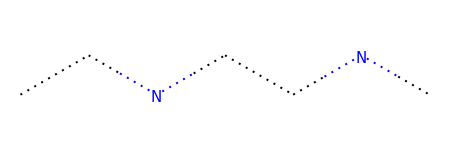

In [100]:
idx_mols_in_m02 = np.where(np.array(alg.instance_graph.vs['community']) == 'm02')[0]
region01 = idx_mols_in_m02[osm4_dataset.X_norm.iloc[idx_mols_in_m02]['C3SP2'] < 0.26] 
region02 = idx_mols_in_m02[(osm4_dataset.X_norm.iloc[idx_mols_in_m02]['nHBDon'] > 0.26)]

smiles_m02 = osm4_dataset.metadata.Canonical_Smiles.iloc[region01]

res = rdFMCS.FindMCS([Chem.MolFromSmiles(mol) for mol in smiles_m02])
pattern = Chem.MolFromSmarts(res.smartsString)
pattern

In [111]:
graph.vs['activity'] = osm4_dataset.y['pIC50'].values
graph.vs['C3SP2'] = osm4_dataset.X_norm['C3SP2'].values

In [112]:
graph.write_gml('/mnt/data/OSM-S4/osm-s4-graph.gml')

### Most representative structure (region 01)

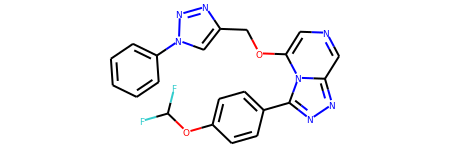

In [124]:
degrees = np.array([alg.instance_graph.vs[i]['degree'] for i in region01])
most_representative = osm4_dataset.metadata.Canonical_Smiles.iloc[region01[np.argmax(degrees)]]
Chem.MolFromSmiles(most_representative)

### Most representative structure (region 02)

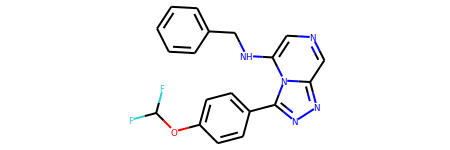

In [125]:
degrees = np.array([alg.instance_graph.vs[i]['degree'] for i in region02])
most_representative = osm4_dataset.metadata.Canonical_Smiles.iloc[region02[np.argmax(degrees)]]
Chem.MolFromSmiles(most_representative)

# Test Set

Predict samples in test set

In [135]:
test_set = pd.read_excel('/mnt/data/OSM-S4/Round 2 Test Set.xlsx')
test_set.shape

(34, 5)

In [ ]:
test_set.set_index('OSM Code', inplace=True)

## Calculate Molecular Descriptors

- Calculate descriptors
- Select only those used by model

In [137]:
cdk_utils = CDKUtils()
test_set_descriptors = cdk_utils.calculate_descriptors(test_set, "SMILES")

(01/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.WHIMDescriptor()
(02/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.BCUTDescriptor()
(03/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.XLogPDescriptor()
(04/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.WeightDescriptor()
(05/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.RuleOfFiveDescriptor()
(06/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.RotatableBondsCountDescriptor()
(07/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.MannholdLogPDescriptor()
(08/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.LargestPiSystemDescriptor()
(09/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.LargestChainDescriptor()
(10/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.BondCountDescrip

In [139]:
test_set_descriptors.index = test_set.index

In [162]:
selected_idx = np.where(test_set_descriptors.iloc[0,].isnull() > 0)[0].tolist()
for i in selected_idx:
    test_set_descriptors.iloc[0, i] = test_set_descriptors.iloc[1, i]

In [170]:
test_set_descriptors.drop(columns=selected_idx, inplace=True)

## Apply modSAR

In [219]:
alg.predict(test_set_descriptors[osm4_dataset.X.columns], test_set['SMILES'])

array([ 5.60205999,  5.60205999,  5.60205999,  5.60205999,  5.60205999,
        5.60205999,  5.60205999,  5.60205999,  5.60205999,  5.60205999,
        5.60205999,  5.60205999,  5.60205999,  5.60205999,  5.60205999,
        5.60205999,  5.60205999,  5.60205999,  5.60205999,  5.60205999,
        5.60205999,  5.60205999,  5.60205999,  5.60205999,  5.60205999,
        5.60205999,  0.53480915,  5.60205999,  5.60205999,  5.60205999,
        5.60205999,  5.60205999,  5.60205999,  6.39725405])

## Apply RF

In [292]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100).fit(osm4_dataset.X, osm4_dataset.y)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [293]:
pred_IC50 = pd.Series(rf.predict(test_set_descriptors[osm4_dataset.X.columns]), name='pIC50')
pred_IC50

0     5.746149
1     5.747858
2     5.836238
3     5.916526
4     5.875322
5     5.902213
6     5.850860
7     5.838736
8     5.811801
9     6.074432
10    5.997910
11    5.982629
12    5.874786
13    6.207376
14    5.855564
15    5.616265
16    5.991672
17    5.928460
18    5.734746
19    5.692078
20    5.808612
21    5.767523
22    5.977625
23    5.783000
24    5.849918
25    5.713313
26    5.620249
27    5.788442
28    5.647886
29    5.895746
30    6.136476
31    6.055940
32    6.142250
33    5.686855
Name: pIC50, dtype: float64

In [294]:
result = pd.concat([test_set['SMILES'], pred_IC50], axis=1)
result['prediction (uM)'] = result.apply(lambda x: math.pow(10, -x['pIC50'],)/(1e-6), axis=1)

In [295]:
result

,SMILES,pIC50,prediction (uM)
0,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCCC4567[BH]...,5.746149,1.794117
1,FC(F)C1(C2)CC2(COC3=CN=CC4=NN=C(C5=CC=C(OC(F)F...,5.747858,1.787072
2,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=C(...,5.836238,1.458014
3,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=C(...,5.916526,1.211921
4,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=C(...,5.875322,1.332533
5,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=CC...,5.902213,1.252527
6,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=C(...,5.850860,1.409742
7,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=CC...,5.838736,1.449654
8,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=CC...,5.811801,1.542405
9,FC(F)OC(C=C1)=CC=C1C2=NN=C3C(OCC(CO)C4=CC=CC=C...,6.074432,0.842496


In [296]:
result.to_csv('/mnt/data/OSM-S4/submission-jonathan-cardoso-silva-rf.csv')

## RF on the modules

Instead of OPLRAreg, use RF on the modules

In [263]:
from collections import Counter

def classify_sample(alg, sample_smiles, cdk_utils=None):
    """"""

    if cdk_utils is None:
        cdk_utils = CDKUtils()

    fp_sample = cdk_utils.calculate_fingerprint(sample_smiles)

    if alg.fingerprints_training is None:
        print("Recalculating fingerprints for samples in the graph.")
        alg.fingerprints_training = [cdk_utils.calculate_fingerprint(smiles)
                                      for smiles in alg.instance_graph.vs['SMILES']]

    similarities = [cdk_utils.cdk.similarity.Tanimoto.calculate(fp_sample, fp_training)
                    for fp_training in alg.fingerprints_training]
    similarities = np.array(similarities)

    neighbours = np.argwhere(similarities >= alg.threshold).flatten()
    if len(neighbours) <= 1:
        neighbours = np.array([similarities.argmax()])

    modules_training = np.array(alg.instance_graph.vs["community"])
    neighbours_modules = Counter(modules_training[neighbours])
    # Maximum number of links to a module
    max_links = neighbours_modules.most_common(1)[0][1]
    max_modules = [k for k, v in neighbours_modules.items() if v == max_links]
    
    if len(max_modules) == 1:
        comm = max_modules[0]
        dist_to_modules = {comm: np.average(similarities[np.argwhere(modules_training == comm).flatten()])}
    else:
        dist_to_modules = {comm: np.average(similarities[np.argwhere(modules_training == comm).flatten()])
                           for comm in max_modules}
    closest_module = max(dist_to_modules, key=lambda x: dist_to_modules[x])
    return closest_module

In [272]:
pd.Series([classify_sample(alg, mol) for mol in test_set['SMILES']]).value_counts()

m02    32
m04     2
dtype: int64

### RF on module m02

In [286]:
from sklearn.ensemble import RandomForestRegressor

idx_mols_in_m02 = np.where(np.array(alg.instance_graph.vs['community']) == 'm02')[0]

rf_m02 = RandomForestRegressor(n_estimators=100)
rf_m02.fit(osm4_dataset.X.iloc[idx_mols_in_m02], osm4_dataset.y.iloc[idx_mols_in_m02])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### RF on module m04

In [287]:
idx_mols_in_m04 = np.where(np.array(alg.instance_graph.vs['community']) == 'm04')[0]

rf_m04 = RandomForestRegressor(n_estimators=100)
rf_m04.fit(osm4_dataset.X.iloc[idx_mols_in_m04], osm4_dataset.y.iloc[idx_mols_in_m04])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [289]:
def apply_custom_rf(df):
    
    # Check which module the module belongs to
    
    module = classify_sample(alg, df['SMILES'])
    row = df.drop(['SMILES']).to_frame().transpose()
    
    if module == 'm02':
        result = rf_m02.predict(row)
    elif module == 'm04':
        result = rf_m04.predict(row)

    return result[0]

predIC50 = pd.concat([test_set_descriptors[osm4_dataset.X.columns], test_set['SMILES']], axis=1)\
                .apply(apply_custom_rf, axis=1)

In [290]:
result = pd.concat([test_set['SMILES'], pred_IC50], axis=1)
result['prediction (uM)'] = result.apply(lambda x: math.pow(10, -x['pIC50'],)/(1e-6), axis=1)

In [291]:
result.to_csv('/mnt/data/OSM-S4/submission-jonathan-cardoso-silva-modular-rf.csv')